# Models

In [1]:
import requests
from IPython.core.display import HTML
styles = requests.get("https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/cs109.css").text
HTML(styles)

## Libraries

In [2]:
import numpy as np
import pandas as pd

# import statsmodels.api as sm
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegressionCV
from sklearn.linear_model import LassoCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

import tensorflow as tf 
from tensorflow.keras.layers import Dense, Dropout 
from tensorflow.keras.models import Sequential
from tensorflow.keras import regularizers

import zipfile

### Read, Split, and Standardize Data

In [3]:
temp = pd.read_csv('data/final_preprocessed.csv')
df = pd.read_csv('data/final_preprocessed.csv')

datetimes = pd.to_datetime(df['created_at'])
df['year'] = [i.year for i in datetimes]
df['month'] = [i.month for i in datetimes]
df['day'] = [i.day for i in datetimes]
df['hour'] = [i.hour for i in datetimes]

df = df.drop(['stock_dif', 'Unnamed: 0', 'text', 'created_at', 'preproc', 'keywords', 'is_retweet','äôs', 'äôt', 'äù', 'üá'], axis = 1)

X_train, X_test, y_train, y_test =train_test_split(df.loc[:, df.columns != 'stock_up'], 
                                                         df.stock_up, test_size=0.2, 
                                                         random_state = 109, 
                                                         stratify = df.stock_up)
index = X_test.index

In [4]:
# Standardize the data
standard_scaler = StandardScaler()
x_fitted_scaler = standard_scaler.fit(X_train)
x_train_transform = x_fitted_scaler.transform(X_train)
x_test_transform = x_fitted_scaler.transform(X_test)
X_train = pd.DataFrame(x_train_transform, columns = X_train.columns)
X_test = pd.DataFrame(x_test_transform, columns = X_test.columns)

<div class='theme'> Linear Regression Model </div>

#### Linear Model

In [5]:
lm = LinearRegression().fit(X_train, y_train)
lm_pred_tr = lm.predict(X_train)
lm_pred_test = lm.predict(X_test)
lm_score_tr = accuracy_score(y_train,[int(round(i)) for i in lm_pred_tr])*100
lm_score_test = accuracy_score(y_test, [int(round(i)) for i in lm_pred_test])*100
print("Linear Model Training Set Accuracy:",str(lm_score_tr)+'%')
print("Linear Model Testing Set Accuracy:",str(lm_score_test)+'%')                  

Linear Model Training Set Accuracy: 59.661883231767256%
Linear Model Testing Set Accuracy: 54.40251572327044%


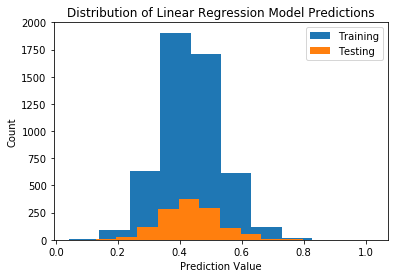

In [6]:
plt.figure()
plt.title('Distribution of Linear Regression Model Predictions')
plt.ylabel('Count')
plt.xlabel('Prediction Value')
plt.hist(lm_pred_tr, label = "Training")
plt.hist(lm_pred_test, label = "Testing")
plt.legend(loc = 'best')

<div class='theme'> Multiple Logistic Regression Model </div>

#### Simple Multiple Logistic Model

In [7]:
#Training
log_model = LogisticRegression(C=100000).fit(X_train, y_train)
#Predict
y_tr_pred = log_model.predict(X_train)
y_test_pred = log_model.predict(X_test)
#Performance Evaluation
tr_score_log = accuracy_score(y_train, y_tr_pred)*100
test_score_log = accuracy_score(y_test, y_test_pred)*100

print("Simple Logistic Model Training Set Accuracy:",str(tr_score_log)+'%')
print("Simple Logistic Model Testing Set Accuracy:",str(test_score_log)+'%')

Simple Logistic Model Training Set Accuracy: 59.81914684489876%
Simple Logistic Model Testing Set Accuracy: 54.166666666666664%


/Users/kendricknguyen/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Text(0.5, 0, 'Probability')

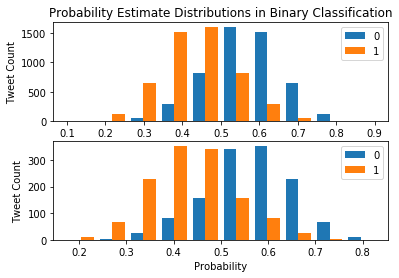

In [8]:
fig, (ax1, ax2) = plt.subplots(2)
ax1.set_title('Probability Estimate Distributions in Binary Classification')
ax1.hist(log_model.predict_proba(X_train), label = ['0', '1'])
ax2.hist(log_model.predict_proba(X_test), label = ['0', '1'])
ax1.legend()
ax2.legend()
ax1.set_ylabel('Tweet Count')
ax2.set_ylabel('Tweet Count')
ax2.set_xlabel('Probability')

#### Regularized Multiple Logistic Model

In [9]:
log_model_cv = LogisticRegressionCV(penalty = 'l2', solver = 'liblinear',cv = 5, max_iter = 10000).fit(X_train, y_train)
#Predict
y_pred_cv = log_model_cv.predict(X_train)
y_pred_test_cv = log_model_cv.predict(X_test)
#Performance Evaluation
tr_score_cv = accuracy_score(y_train, y_pred_cv)*100
test_score_cv = accuracy_score(y_test, y_pred_test_cv)*100

print("Regularized Logistic Model Training Set Accuracy:",str(tr_score_cv)+'%')
print("Regularized Logistic Model Testing Set Accuracy:",str(test_score_cv)+'%')

Regularized Logistic Model Training Set Accuracy: 59.11146058580697%
Regularized Logistic Model Testing Set Accuracy: 54.87421383647799%


Text(0.5, 0, 'Probability')

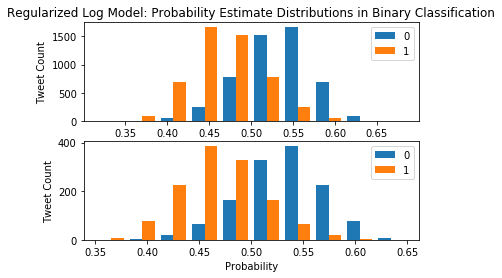

In [10]:
fig, (ax1, ax2) = plt.subplots(2)
ax1.set_title('Regularized Log Model: Probability Estimate Distributions in Binary Classification')
ax1.hist(log_model_cv.predict_proba(X_train), label = ['0', '1'])
ax2.hist(log_model_cv.predict_proba(X_test), label = ['0', '1'])
ax1.legend()
ax2.legend()
ax1.set_ylabel('Tweet Count')
ax2.set_ylabel('Tweet Count')
ax2.set_xlabel('Probability')

<div class='theme'> Random Forest Model </div>

##### Finding the Best Depth for Random Forest Classifier

In [11]:
def calc_meanstd(X_train, y_train, depths):
    train_scores = {}
    cvmeans = {}
    cvstds = {}
    for depth in depths:
        model = DecisionTreeClassifier(max_depth = depth)
        score = cross_val_score(estimator=model, X = X_train, y = y_train, cv=5, n_jobs = -1)
        train_scores[depth] = score
        cvmeans[depth] = score.mean()
        cvstds[depth] = score.std()
    return cvmeans, cvstds, train_scores

cvmeans, cvstds, train_scores = calc_meanstd(X_train, y_train, depths = list(range(1,51)))
best_depth = max(cvmeans, key=cvmeans.get)

#### Random Forest Model

In [12]:
rf_model = RandomForestClassifier(n_estimators = 50, max_depth = 6, max_features = 'sqrt').fit(X_train, y_train)
random_forest_test_score = accuracy_score(y_test, rf_model.predict(X_test))*100
random_forest_train_score = accuracy_score(y_train, rf_model.predict(X_train))*100
print('Random Forest Model Training Accuracy Score: ', random_forest_train_score, '%')
print('Random Forest Model Testing Accuracy Score: ', random_forest_test_score, '%')

Random Forest Model Training Accuracy Score:  65.48063691763318 %
Random Forest Model Testing Accuracy Score:  56.60377358490566 %


##### Visualization

In [13]:
def graph_acc(depth):
    testing = {}
    training = {}
    for i in range(depth):
        rf = RandomForestClassifier(n_estimators = 50, max_depth = i+1, max_features = 'sqrt').fit(X_train, y_train)
        training[i] = accuracy_score(y_train, rf.predict(X_train))
        testing[i] = accuracy_score(y_test, rf.predict(X_test))
    return training, testing
tr_list, test_list = graph_acc(10)

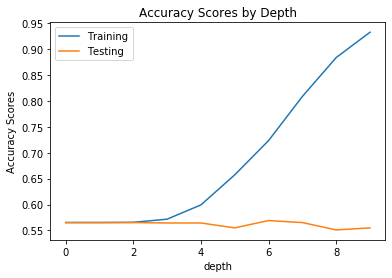

In [14]:
plt.figure()
plt.title('Accuracy Scores by Depth')
plt.xlabel('depth')
plt.ylabel('Accuracy Scores')
plt.plot(*zip(*sorted(tr_list.items())), label = 'Training')
plt.plot(*zip(*sorted(test_list.items())), label = 'Testing')
plt.legend(loc = 'upper left')
plt.show()

Text(0.5, 0, 'Probability')

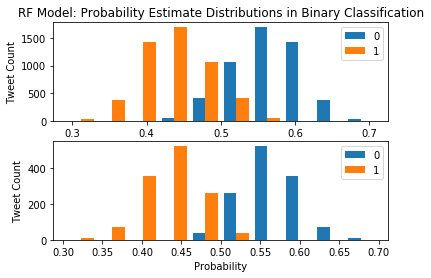

In [15]:
fig, (ax1, ax2) = plt.subplots(2)
ax1.set_title('RF Model: Probability Estimate Distributions in Binary Classification')
ax1.hist(rf_model.predict_proba(X_train), label = ['0', '1'])
ax2.hist(rf_model.predict_proba(X_test), label = ['0', '1'])
ax1.legend()
ax2.legend()
ax1.set_ylabel('Tweet Count')
ax2.set_ylabel('Tweet Count')
ax2.set_xlabel('Probability')

In [16]:
predictions = pd.DataFrame(rf_model.predict(X_test), index = index)
dates = pd.DataFrame(datetimes[index], index = index)
rf_prediction = pd.concat([predictions, dates], axis = 1)
# rf_prediction.to_csv('data/rf_prediction')

##### Most important features from Random Forest Model

In [17]:
feature_list = dict(zip(X_train.columns.values, rf_model.feature_importances_))
top_10_features = sorted(feature_list, key = feature_list.get, reverse = True)[:10]
top_10_features

['favorite_count',
 'say',
 'really',
 'nation',
 'story',
 'totally',
 'governor',
 'fake',
 'billion',
 'america']

<div class='theme'> Neural Network </div>

In [18]:
model = Sequential()
model.add(Dense(16, input_shape = (152,), activation = 'relu'))
model.add(Dense(32, activation = 'relu',kernel_regularizer=regularizers.l2(0.01)))
model.add(Dropout(.6))
model.add(Dense(1, activation = 'sigmoid'))
model.compile(optimizer = 'adam',loss = 'binary_crossentropy', metrics = ['accuracy'])

In [19]:
hist = model.fit(X_train, y_train, validation_split = .2, batch_size = 32, epochs = 50)

Train on 4069 samples, validate on 1018 samples
Epoch 1/50
4069/4069 [==============================] - 0s 102us/sample - loss: 0.9264 - accuracy: 0.5131 - val_loss: 0.8310 - val_accuracy: 0.5481
Epoch 2/50
4069/4069 [==============================] - 0s 62us/sample - loss: 0.8225 - accuracy: 0.5358 - val_loss: 0.7838 - val_accuracy: 0.5747
Epoch 3/50
4069/4069 [==============================] - 0s 77us/sample - loss: 0.7722 - accuracy: 0.5591 - val_loss: 0.7539 - val_accuracy: 0.5727
Epoch 4/50
4069/4069 [==============================] - 0s 80us/sample - loss: 0.7421 - accuracy: 0.5648 - val_loss: 0.7357 - val_accuracy: 0.5727
Epoch 5/50
4069/4069 [==============================] - 0s 58us/sample - loss: 0.7239 - accuracy: 0.5788 - val_loss: 0.7246 - val_accuracy: 0.5599
Epoch 6/50
4069/4069 [==============================] - 0s 62us/sample - loss: 0.7078 - accuracy: 0.5832 - val_loss: 0.7169 - val_accuracy: 0.5658
Epoch 7/50
4069/4069 [==============================] - 0s 82us/sampl

##### Visualization

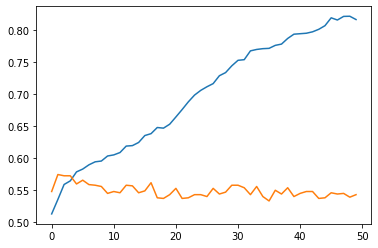

In [20]:
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])

##### Neural Network Results

In [21]:
predictions_train = model.predict(X_train)
predictions_test = model.predict(X_test)
prediction = pd.DataFrame(predictions_test, index = X_test.index)
dates = temp.iloc[X_test.index]['created_at']
neural_predict = pd.concat([prediction, dates], axis = 1)
# neural_predict.to_csv('data/neural_prediction')

In [22]:
predict_tr = [1 if x > .9 else 0 for x in predictions_train]
predict_test = [1 if x > .9 else 0 for x in predictions_test]
nn_tr_score = accuracy_score(y_train, predict_tr)*100
nn_test_score = accuracy_score(y_test, predict_test)*100
# index = np.where(prediction[0] > .9)[0]
# top_tweet = temp.iloc[np.where(prediction[0] > .90)]['text'][488]
# print('tweet that would raise stock market is: ', top_tweet)
# worst_tweet = temp.iloc[np.where(prediction[0] < .01)]['text'][899]
# print('tweet that would lower stock market is: ', worst_tweet)

# Model Results

In [23]:
names = []
scores = []
scores.append([[lm_score_tr, lm_score_test], [tr_score_log, test_score_log],
               [tr_score_cv, test_score_cv], [random_forest_train_score, random_forest_test_score], [nn_tr_score, nn_test_score]])
names.append(['Linear Regression', 'Simple Logistic', 'Regularized Logistic', 'Random Forest', 'Neural Network'])
results_df = pd.DataFrame(scores[0], index = names[0], columns = ['Training Accuracy (%)', 'Testing Accuracy (%)'])
results_df

,Training Accuracy (%),Testing Accuracy (%)
Linear Regression,59.661883,54.402516
Simple Logistic,59.819147,54.166667
Regularized Logistic,59.111461,54.874214
Random Forest,65.480637,56.603774
Neural Network,69.785728,55.345912


# Best Model: Random Forest

## Feature Importance 

In [24]:
feature_list = dict(zip(X_train.columns.values, rf_model.feature_importances_))
top_10_features = sorted(feature_list, key = feature_list.get, reverse = True)[:10]
print('the best features were \n',top_10_features)

the best features were 
 ['favorite_count', 'say', 'really', 'nation', 'story', 'totally', 'governor', 'fake', 'billion', 'america']


Text(0.5, 0, 'Predictors')

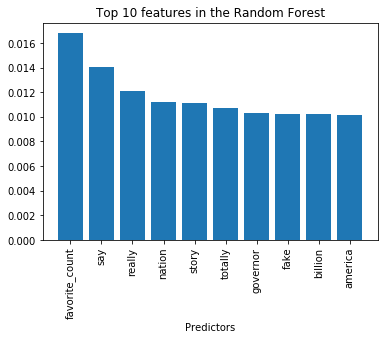

In [25]:
importance_rf_values = []
for i in top_10_features:
    importance_rf_values.append(feature_list.get(i))
plt.bar(np.arange(0, len(importance_rf_values)), importance_rf_values, tick_label = top_10_features)
plt.xticks(rotation = 90)
plt.title('Top 10 features in the Random Forest')
plt.xlabel('Predictors')

In [26]:
worst_10_features = sorted(feature_list, key = feature_list.get, reverse = True)[-10:]
print('the worst features were \n', worst_10_features)

the worst features were 
 ['administration', 'many', 'win', 'news', 'law', 'like', 'record', 'bill', 'subjectivity', 'year']


Text(0.5, 0, 'Predictors')

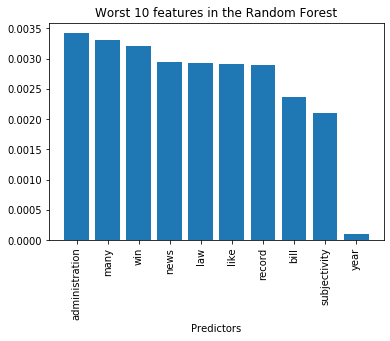

In [27]:
nimportance_rf_values = []
for i in worst_10_features:
    nimportance_rf_values.append(feature_list.get(i))
plt.bar(np.arange(0, len(nimportance_rf_values)), nimportance_rf_values, tick_label = worst_10_features)
plt.xticks(rotation = 90)
plt.title('Worst 10 features in the Random Forest')
plt.xlabel('Predictors')

## Error Analysis 

original rf 
 [[699  20]
 [532  21]]
forced rf 
 [[346 373]
 [290 263]]


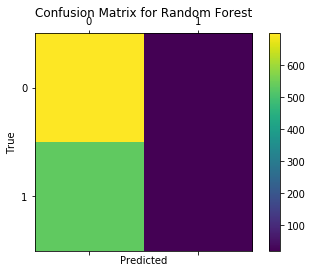

In [28]:
from sklearn.metrics import confusion_matrix
original_rf_matrix = confusion_matrix(y_test, rf_model.predict(X_test))
print('original rf \n' , original_rf_matrix)
distribution = pd.DataFrame(rf_model.predict_proba(X_test))[1]
half = np.quantile(distribution, .5)
forced_rf_predictions = [0 if x > half else 1 for x in distribution]
forced_rf_matrix = confusion_matrix(y_test, forced_rf_predictions)
print('forced rf \n' , forced_rf_matrix )
figure, axis = plt.subplots()

color = axis.matshow(original_rf_matrix)
figure.colorbar(color)
axis.set_xlabel('Predicted')
axis.set_ylabel('True')
axis.set_title('Confusion Matrix for Random Forest')
plt.show()

Text(0, 0.5, 'Accuracy')

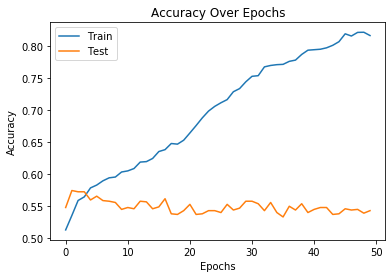

In [29]:
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.legend(['Train', 'Test'])
plt.title('Accuracy Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')

Comment: Very high False negatives. Many predicted 0s were 1s. 

## Examples of Predictions 

In [30]:
stock_up_prediction  = min(distribution)
print('tweet associated with highest probability of stock going up \n \n',temp.iloc[index[np.where(distribution == stock_up_prediction)[0]]]['text'].values)

print('\n')
stock_down_prediction  = max(distribution)
print('tweet associated with highest probability of stock going down \n \n ', temp.iloc[index[np.where(distribution == stock_down_prediction)[0]]]['text'].values)

tweet associated with highest probability of stock going up 
 
 ['Gina is Great! https://t.co/TyLQ2W42y5']


tweet associated with highest probability of stock going down 
 
  ['.....Ice Border Patrol and our Military have done a FANTASTIC job of securing our Southern Border. A Great Wall would be however a far easier &amp; less expensive solution. We have already built large new sections &amp; fully renovated others making them like new. The Democrats.....']


Text(0.5, 1.0, 'Distribution of Predicted Probabilities - Random Forest')

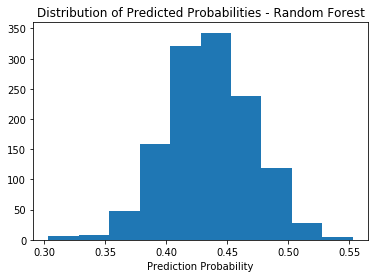

In [31]:
plt.hist(distribution)
plt.xlabel('Prediction Probability')
plt.title('Distribution of Predicted Probabilities - Random Forest')

# Second Best: Neural Network

## Error Analysis 

original neural 
 [[626  93]
 [475  78]]


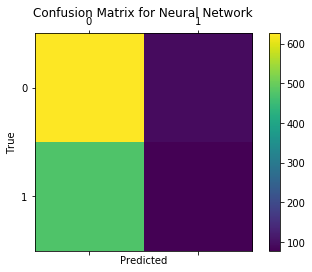

In [32]:
from sklearn.metrics import confusion_matrix
original_neural_matrix = confusion_matrix(y_test,predict_test)
print('original neural \n' , original_neural_matrix)
figure, axis = plt.subplots()

color = axis.matshow(original_neural_matrix)
figure.colorbar(color)
axis.set_xlabel('Predicted')
axis.set_ylabel('True')
axis.set_title('Confusion Matrix for Neural Network')
plt.show()

## Example of Predictions

In [33]:
stock_up_prediction_neural = np.where(predictions_test == max(predictions_test))[0]
print('tweet associated with highest probability of stock going up \n \n', temp.iloc[index[stock_up_prediction_neural]]['text'].values)

print('\n')
stock_down_prediction_neural = np.where(predictions_test == min(predictions_test))[0]
print('tweet associated with highest probability of stock going down \n \n ',temp.iloc[index[stock_down_prediction_neural]]['text'].values)

tweet associated with highest probability of stock going up 
 
 ['Alan Dershowitz Harvard Law Professor: ‚ÄúIt all proves that we never needed a Special Councel....All of this could have been done by the Justice Dept. Don‚Äôt need a multi-million dollar group of people with a target on someone‚Äôs back. Not the way Justice should operate.‚Äù So true!']


tweet associated with highest probability of stock going down 
 
  ['This week the Senate can join the House &amp; take a strong stand for the Middle Class families who are the backbone of America. Together we will give the American people a big beautiful Christmas present-a massive tax cut that lets Americans keep more of their HARD-EARNED MONEY! https://t.co/9jddEW2Oo5']


Text(0.5, 1.0, 'Distribution of Predicted Probabilities - Neural Network')

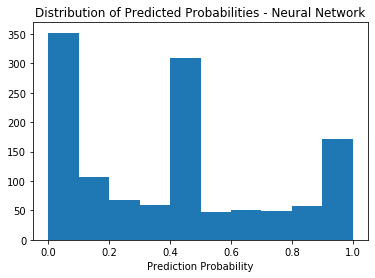

In [34]:
plt.hist(predictions_test)
plt.xlabel('Prediction Probability')
plt.title('Distribution of Predicted Probabilities - Neural Network')

## Trends of Misclassification of Models

It is clear that the most of the errors are False Negative for both our Random Forest and Neural Network models. Both models tend to estimate conservatively. However, for the neural network, for those tweets that are associted with stock going up, the probability is very high. 